# DEMO 

Read in the intake catalogues from the input to bias correction



#### required packages

In [1]:
import intake
import xarray as xr
from matplotlib import pyplot as plt

import glob
import pathlib
import traceback
from datetime import datetime

from xclim.indices import (
    keetch_byram_drought_index,
    griffiths_drought_factor,
    mcarthur_forest_fire_danger_index
)


#### start a local Dask client

In [2]:
from dask.distributed import Client
client = Client()
client

2024-06-13 13:58:11,969 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-06-13 13:58:11,972 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-06-13 13:58:11,996 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0432.gadi.nci.org.au/37720/proxy/8787/status,
Dashboard: /node/gadi-cpu-bdw-0432.gadi.nci.org.au/37720/proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35973,Workers: 28
Dashboard: /node/gadi-cpu-bdw-0432.gadi.nci.org.au/37720/proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39125,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0432.gadi.nci.org.au/37720/proxy/40853/status,Memory: 0 B
Nanny: tcp://127.0.0.1:43507,


#### ignore warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Obtain the desired catalogues of the simulations to processe

In [4]:
catalogue_path='/g/data/ia39/catalogues'
mRuns = sorted(glob.glob(catalogue_path+'/*ssp370*.json'))
print(len(mRuns))

13


In [5]:
# test loading all the catalogues of the data
for file in mRuns: 
    print(file)
    cat1=intake.open_esm_datastore(file)

/g/data/ia39/catalogues/AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_BOM_ACCESS-ESM1-5_ssp370_r6i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_BOM_CESM2_ssp370_r11i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_BOM_CMCC-ESM2_ssp370_r1i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_BOM_EC-Earth3_ssp370_r1i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_BOM_MPI-ESM1-2-HR_ssp370_r1i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_BOM_NorESM2-MM_ssp370_r1i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_CSIRO_ACCESS-CM2_ssp370_r4i1p1f1_CCAM-v2203-SN_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_CSIRO_ACCESS-ESM1-5_ssp370_r6i1p1f1_CCAM-v2203-SN_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_CSIRO_CESM2_ssp370_r11i1p1f1_CCAM-v2203-SN_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_CSIRO_CMCC-ESM2_ssp370_r1i1p1f1_CCAM-v2203-SN_v1-r1_day.json
/g/data/ia39/

# Process one ensemble 

In [6]:
# From one catalogue list save variables
mindex=12  # run to process
mindex=12
cat=intake.open_esm_datastore(mRuns[mindex])
mtmp=mRuns[mindex].split('/')
model_name=mtmp[5].split('.')
print(model_name)
print(cat.unique()['variable']) #unique()['variable']
tmp=model_name[0].split('_'); ACS_model=tmp[1]

['AGCD-05i_CSIRO_EC-Earth3_ssp370_r1i1p1f1_CCAM-v2203-SN_v1-r1_day', 'json']
['hursmax', 'hursmin', 'pr', 'rsds', 'sfcWindmax', 'tasmax', 'tasmin']


In [14]:
%%time
# read in a few variables from one member
#)#,'tasmax','hursmin'})#,'sfcWindmax'})
#cat_subset=cat.search(variable={'pr'})#,'tasmax','hursmin'})#,'sfcWindmax'})
pr = cat.search(variable={'pr'}).to_dask(cdf_kwargs={'chunks': {'time': -1, 'lat': 691, 'lon': 886}})
tasmax = cat.search(variable={'tasmax'}).to_dask(cdf_kwargs={'chunks': {'time': 365, 'lat': 691, 'lon': 886}})
hursmin = cat.search(variable={'hursmin'}).to_dask(cdf_kwargs={'chunks': {'time': 365, 'lat': 691, 'lon': 886}})
sfcWindmax = cat.search(variable={'sfcWindmax'}).to_dask(cdf_kwargs={'chunks': {'time': 365, 'lat': 691, 'lon': 886}})

# hursmin has a different time axis than the other variables!
# could do two seperate datasets to deal with the different tima axis but not doing now.
hursmin=hursmin.assign_coords(time= pr.time)

# BoM files have height coordinate in the sfcWindmax that needs to be removed
if ACS_model == 'BOM':
    sfcWindmax=sfcWindmax.reset_coords('height', drop=True)
    tasmax=tasmax.reset_coords('height', drop=True)
    hursmin=hursmin.reset_coords({'height','level_height','model_level_number','sigma'}, drop=True)

#hursmin

CPU times: user 21.2 s, sys: 2.34 s, total: 23.6 s
Wall time: 32.6 s


In [15]:
pr

<xarray.Dataset>
Dimensions:    (time: 31025, lat: 691, lon: 886, bnds: 2)
Coordinates:
  * time       (time) object 2015-01-01 12:00:00 ... 2099-12-31 12:00:00
  * lat        (lat) float64 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon        (lon) float64 112.0 112.0 112.1 112.2 ... 156.1 156.2 156.2 156.2
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(691, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(886, 2), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(365, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 dask.array<chunksize=(365, 691, 886), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                         CF-1.10
    activity_id:                         DD
    contact:                             ccam@csiro.au
    domain:                              Australia/AGCD
    domain_id:                           AGCD-05i
    driving_experiment:                  gap-filling scenario reaching 7.0 ba...
    ...                                  ...
    intake_esm_attrs:downscale_model:    CSIRO
    intake_esm_attrs:downscale_version:  CCAM-v2203-SN
    intake_esm_attrs:period:             v1-r1
    intake_esm_attrs:time_period:        fixed
    intake_esm_attrs:_data_format_:      netcdf
    intake_esm_dataset_key:              AGCD-05i.EC-Earth3.ssp370.r1i1p1f1.C...

In [16]:
from rechunker import rechunk

target_chunks = (31025, 886, 6)
max_mem = "4GB"
target_chunks = {
    "pr": {"time": 31025, "lat": 691, "lon": 10},
    "time": None,  # don't rechunk this array
    "lon": None,
    "lat": None,
}
#!rm -rf /scratch/xv83/rxm599/pr_rechunked.zarr /scratch/xv83/rxm599/pr_rechunked-tmp.zarr
root_store = "/scratch/xv83/rxm599/rechunked"
temp_store = "/scratch/xv83/rxm599/rechunked-tmp.zarr"

In [17]:

!rm -rf /scratch/xv83/rxm599/rechunk* 
target_store=root_store+'_pr.zarr'
temp_store = "/scratch/xv83/rxm599/rechunked-tmp1.zarr"
print(target_store)
array_plan1 = rechunk(pr
    , target_chunks, max_mem, target_store, temp_store=temp_store )

target_store=root_store+'_tasmax.zarr'
temp_store = "/scratch/xv83/rxm599/rechunked-tmp2.zarr"
array_plan2 = rechunk(tasmax
    , target_chunks, max_mem, target_store, temp_store=temp_store )

target_store=root_store+'_hursmin.zarr'
temp_store = "/scratch/xv83/rxm599/rechunked-tmp3.zarr"
array_plan3 = rechunk(hursmin
    , target_chunks, max_mem, target_store, temp_store=temp_store )

target_store=root_store+'_sfcWindmax.zarr'
temp_store = "/scratch/xv83/rxm599/rechunked-tmp4.zarr"
array_plan4 = rechunk(sfcWindmax
    , target_chunks, max_mem, target_store, temp_store=temp_store )

/scratch/xv83/rxm599/rechunked_pr.zarr


In [18]:
%%time
!rm -rf /scratch/xv83/rxm599/rechunked-tmp1.zarr
array_plan1.execute()
!rm -rf /scratch/xv83/rxm599/rechunked-tmp2.zarr
array_plan2.execute()
!rm -rf /scratch/xv83/rxm599/rechunked-tmp3.zarr
array_plan3.execute()
!rm -rf /scratch/xv83/rxm599/rechunked-tmp4.zarr
array_plan4.execute()

RuntimeError: Error during deserialization of the task graph. This frequently
occurs if the Scheduler and Client have different environments.
For more information, see
https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments


In [11]:
dr=xr.open_zarr("/scratch/xv83/rxm599/pr_rechunked.zarr")
dr

0.3.0


<xarray.Dataset>
Dimensions:    (lat: 691, bnds: 2, lon: 886, time: 31025)
Coordinates:
  * lat        (lat) float64 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(691, 2), meta=np.ndarray>
  * lon        (lon) float64 112.0 112.0 112.1 112.2 ... 156.1 156.2 156.2 156.2
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(886, 2), meta=np.ndarray>
  * time       (time) object 2015-01-01 12:00:00 ... 2099-12-31 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(31025, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 dask.array<chunksize=(31025, 691, 10), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                         CF-1.10
    NCO:                                 netCDF Operators version 5.0.5 (Home...
    activity_id:                         DD
    contact:                             ccam@csiro.au
    domain:                              Australia/AGCD
    domain_id:                           AGCD-05i
    ...                                  ...
    source:                              Conformal Cubic Atmospheric Model v2203
    source_id:                           CCAM-v2203-SN
    source_type:                         AOGCM
    title:                               Pre-processed model output in prepar...
    variable_id:                         pr
    version_realisation:                 v1-r1

## Calculate FFDI 

In [30]:
%%time
# This is usually computed over a specific period
#pr_annual = dsets.pr.resample(time="A").sum().mean("time")
pr_annual = pr.pr.resample(time="Y").sum().\
    sel(time=slice('2015-01-01', '2035-01-01')).mean("time").\
    assign_attrs(
    units="mm a-1", long_name="Annual average rainfall")

pr_annual

CPU times: user 1.61 s, sys: 342 ms, total: 1.96 s
Wall time: 5.67 s


<xarray.DataArray 'pr' (lat: 691, lon: 886)>
dask.array<mean_agg-aggregate, shape=(691, 886), dtype=float32, chunksize=(691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 112.0 112.0 112.1 112.2 ... 156.1 156.2 156.2 156.2
Attributes:
    units:      mm a-1
    long_name:  Annual average rainfall

In [64]:
t1='2015-01-01'; t2='2015-12-31'
pra=pr.pr.sel(time=slice(t1, t2))
tasmaxa=tasmax.tasmax.sel(time=slice(t1,t2))
hursmina=hursmin.hursmin.sel(time=slice(t1,t2))
sfcWindmaxa=sfcWindmax.sfcWindmax.sel(time=slice(t1,t2))
#pra,tasmaxa,hursmina,sfcWindmaxa

In [65]:
KBDI = keetch_byram_drought_index(pra, tasmaxa, pr_annual) 
DF = griffiths_drought_factor(pra, KBDI)
FFDI = mcarthur_forest_fire_danger_index(DF, tasmaxa, hursmina, sfcWindmaxa)
ds = FFDI.to_dataset(name='FFDI')

In [66]:
%%time
FFDI.to_netcdf('/g/data/ia39/ncra/fire/'+model_name[0]+'_FFDI.nc')

CPU times: user 30.7 s, sys: 4.11 s, total: 34.8 s
Wall time: 1min 29s


In [67]:
%%time
ds.to_zarr('/g/data/ia39/ncra/fire/'+model_name[0]+'_FFDI.zar',mode='w')

CPU times: user 32.3 s, sys: 4.77 s, total: 37.1 s
Wall time: 1min 38s


# The End  added some extra plotting to check the input info

In [68]:
#client.shutdown()

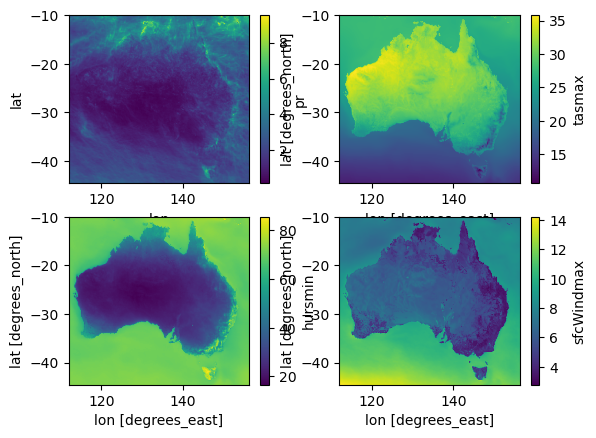

In [69]:
plt.subplot(2,2,1); pra.mean('time').plot()
plt.subplot(2,2,2); tasmaxa.mean('time').plot()
plt.subplot(2,2,3); hursmina.mean('time').plot()
plt.subplot(2,2,4); sfcWindmaxa.mean('time').plot()

In [70]:
ds=xr.open_zarr('/g/data/ia39/ncra/fire/'+model_name[0]+'_FFDI.zar')
#ffdi=xr.open_zarr('/g/data/ia39/ncra/fire/'+'AGCD-05i_CSIRO_EC-Earth3_ssp370_r1i1p1f1_CCAM-v2203-SN_v1-r1_day_FFDI.zar')
ds

<xarray.Dataset>
Dimensions:  (lat: 691, lon: 886, time: 365)
Coordinates:
  * lat      (lat) float64 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 112.0 112.0 112.1 112.2 ... 156.1 156.2 156.2 156.2
  * time     (time) object 2015-01-01 12:00:00 ... 2015-12-31 12:00:00
Data variables:
    FFDI     (lat, lon, time) float32 dask.array<chunksize=(691, 886, 365), meta=np.ndarray>

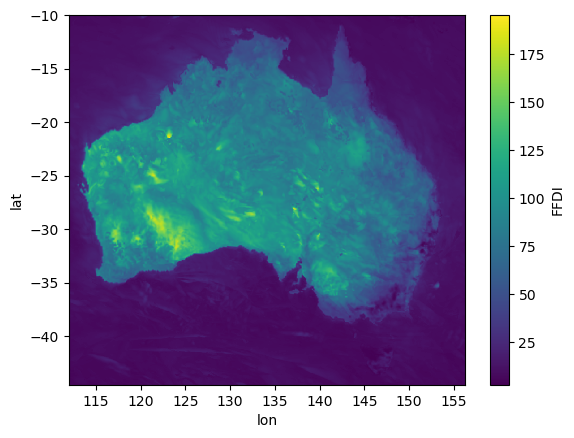

In [71]:
ds.FFDI.max('time').plot()